# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Friday, October 24, 2025, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a multilayer perceptron (MLP).

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  

> Good luck, comrade!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

2025-10-24 20:52:53.343433: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 20:52:53.346841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 20:52:53.584957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 20:52:54.907177: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a multilayer perceptron (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering.
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Improve performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning hyperparameters.

> Note: There are no restrictions on the tricks you can use — Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How can you make sure the results are reproduable?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between SGD and Adam.
   - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

In [2]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

In [3]:
import os
import random

# Clear any previous TensorFlow session
keras.backend.clear_session()

# Set all seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)

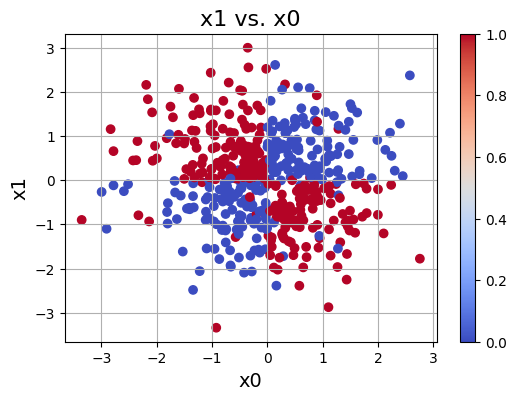

In [4]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

In [5]:
X_train = train[['x0', 'x1']].values
y_train = train['y'].values
X_test = test[['x0', 'x1']].values
y_test = test['y'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Stratified split to ensure balanced train/val sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, 
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

print(f"Train: {X_train_final.shape}, Val: {X_val.shape}")
print(f"Train class dist: {np.bincount(y_train_final.astype(int))}")
print(f"Val class dist: {np.bincount(y_val.astype(int))}")

Train: (400, 2), Val: (100, 2)
Train class dist: [190 210]
Val class dist: [48 52]


In [7]:
# %% Custom Learning Rate Scheduler
class WarmupCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    """Warmup + Cosine Decay LR Schedule"""
    
    def __init__(self, max_lr, total_steps, warmup_steps, min_lr=0.0):
        super().__init__()
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        
        warmup_lr = self.max_lr * (step / self.warmup_steps)
        
        progress = (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        cosine_decay = 0.5 * (1.0 + tf.cos(np.pi * progress))
        decay_lr = self.min_lr + (self.max_lr - self.min_lr) * cosine_decay
        
        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: decay_lr
        )

In [8]:
# %% Model Architecture - Option 1: Regularized Model
def create_mlp_regularized(input_dim=2, dropout=0.5):
    """2-layer model with heavy regularization, did not work well enough"""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [9]:
# %% Model Architecture - Option 2: Simple Uniform 
def create_mlp_uniform(input_dim=2):
    """4-layer uniform model, no regularization"""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu' ),
        layers.Dense(64, activation='relu' ),
        layers.Dense(64, activation='relu' ),
        layers.Dense(64, activation='relu' ),
        layers.Dense(64, activation='relu' ),
        layers.Dense(64, activation='relu' ),
        layers.Dense(2, activation='softmax')
    ])
    return model

In [10]:

# %% Training Configuration
EPOCHS = 100
BATCH_SIZE = 16
MAX_LR = 0.001
WARMUP_EPOCHS = 20

steps_per_epoch = len(X_train_final) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch
warmup_steps = WARMUP_EPOCHS * steps_per_epoch

lr_schedule = WarmupCosineDecay(
    max_lr=MAX_LR,
    total_steps=total_steps,
    warmup_steps=warmup_steps,
    min_lr=MAX_LR * 0.01
)

In [11]:
# %% Build and Compile Model
# Choose one model:
model = create_mlp_uniform(input_dim=2)

# For uniform model (softmax with 2 outputs):
y_train_int = y_train_final.astype(int)
y_val_int = y_val.astype(int)
y_test_int = y_test.astype(int)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2025-10-24 20:52:56.156196: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,122 (82.51 KB)

 Trainable params: 21,122 (82.51 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train_final, y_train_int,
    validation_data=(X_val, y_val_int),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5400 - loss: 0.6930 - val_accuracy: 0.7900 - val_loss: 0.6886
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8450 - loss: 0.6862 - val_accuracy: 0.9300 - val_loss: 0.6783
Epoch 3/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8750 - loss: 0.6844

2025-10-24 20:52:57.241780: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9175 - loss: 0.6723 - val_accuracy: 0.9400 - val_loss: 0.6570
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8975 - loss: 0.6404 - val_accuracy: 0.9500 - val_loss: 0.6037
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9150 - loss: 0.5610 - val_accuracy: 0.9300 - val_loss: 0.4806
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9150 - loss: 0.4173 - val_accuracy: 0.9300 - val_loss: 0.3315
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9200 - loss: 0.3243 - val_accuracy: 0.9200 - val_loss: 0.3028
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9150 - loss: 0.3085 - val_accuracy: 0.9200 - val_loss: 0.3056
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9150 - loss: 0.3003 - val_accuracy: 0.9200 - val_loss: 0.3089
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9150 - loss: 0.2929 - val_accuracy: 0.9400 - val_loss: 0.

In [13]:

# %% Evaluate Model
train_acc = model.evaluate(X_train_final, y_train_int, verbose=0)[1]
val_acc = model.evaluate(X_val, y_val_int, verbose=0)[1]
test_acc = model.evaluate(X_test_scaled, y_test_int, verbose=0)[1]

print(f"\n{'='*50}")
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"Train-Val Gap:       {train_acc - val_acc:+.4f}")
print(f"{'='*50}\n")

if test_acc >= 0.92:
    print("✅ TARGET ACHIEVED! Test accuracy >= 0.92")
else:
    print(f"⚠️ Need {0.92 - test_acc:.4f} more accuracy")




Training Accuracy:   0.9600
Validation Accuracy: 0.9200
Test Accuracy:       0.9280
Train-Val Gap:       +0.0400

✅ TARGET ACHIEVED! Test accuracy >= 0.92


2025-10-24 20:53:03.585374: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


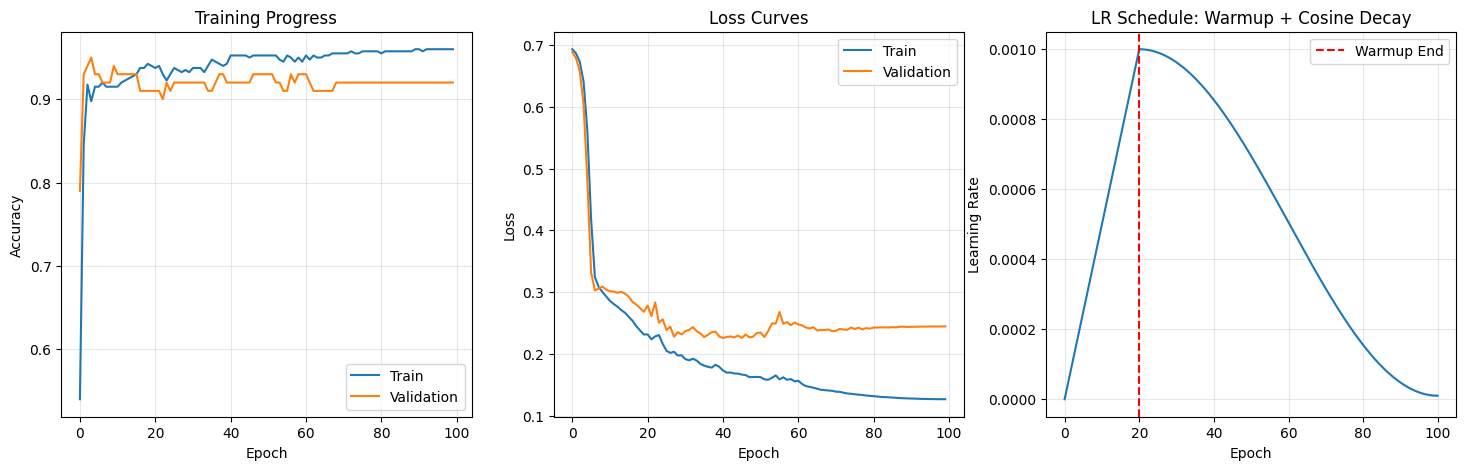

In [14]:
# %% Visualize Results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training curves
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss curves
axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate schedule
steps = np.arange(0, total_steps)
lrs = [lr_schedule(step).numpy() for step in steps]
epochs_x = steps / steps_per_epoch
axes[2].plot(epochs_x, lrs)
axes[2].axvline(x=WARMUP_EPOCHS, color='r', linestyle='--', label='Warmup End')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('LR Schedule: Warmup + Cosine Decay')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.show()

### **Discussion**:
   - How can you make sure the results are reproduable?

To make sure the results are reproducible i set the random seed for libraries and clear the last tensorflow session, then i restart the kernel and test that the results are the exact same a couble of times
   - Visualize the network's architecture and decision boundary.


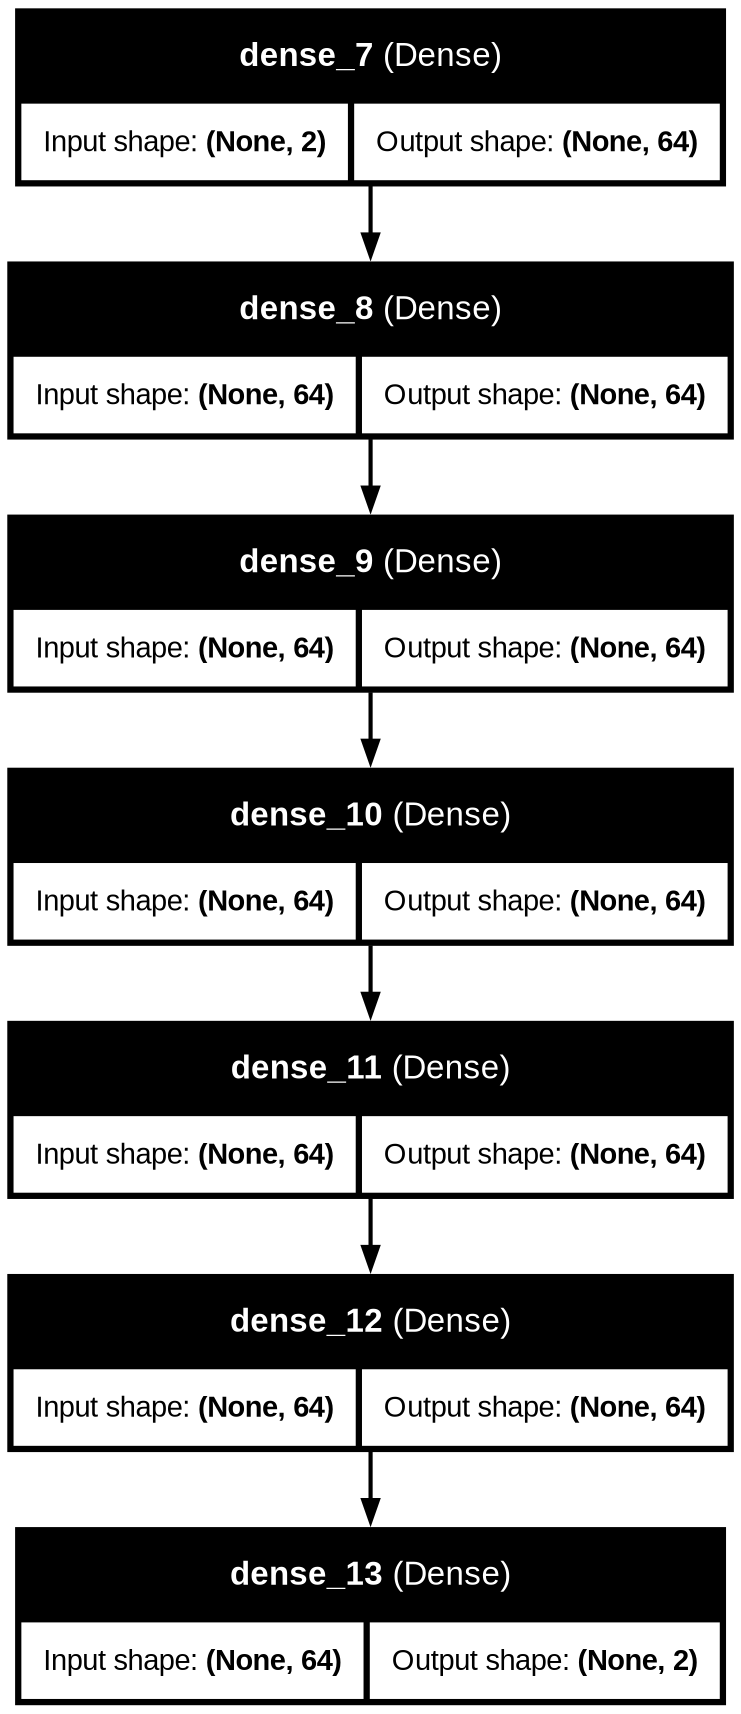

In [15]:
# Generate architecture diagram
from tensorflow.keras.utils import plot_model

model = create_mlp_uniform(input_dim=2)
plot_model(
    model, 
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # Top to bottom
    dpi=150
)

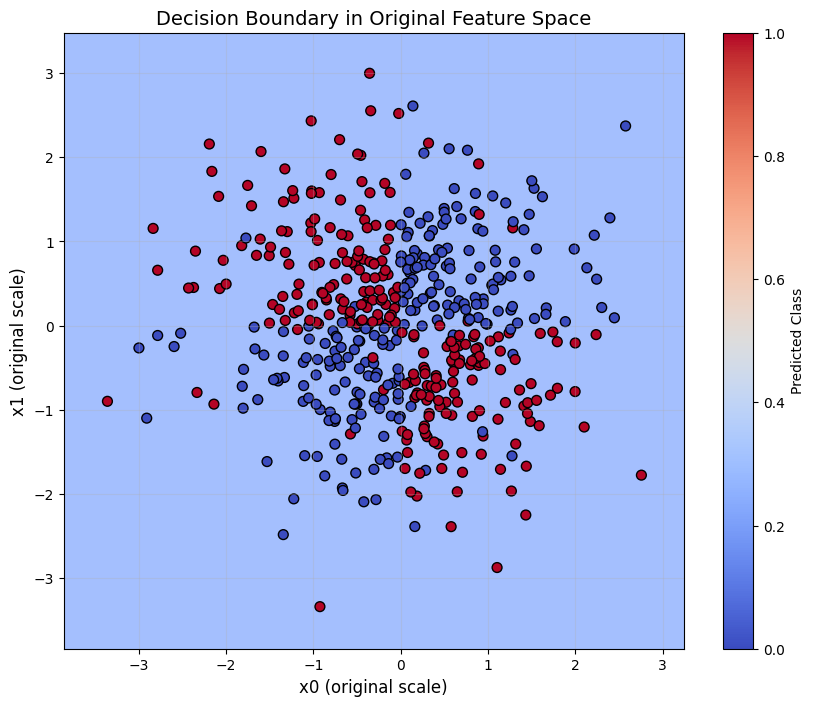

In [16]:
def plot_decision_boundary_original(model, scaler, X_original, y, title='Decision Boundary'):
    """Plot decision boundary in original (unscaled) feature space"""
    h = 0.02
    x_min, x_max = X_original[:, 0].min() - 0.5, X_original[:, 0].max() + 0.5
    y_min, y_max = X_original[:, 1].min() - 0.5, X_original[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Scale the grid points before passing to model
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_scaled = scaler.transform(grid_points)
    
    # Make predictions on scaled grid
    Z = model.predict(grid_points_scaled, verbose=0)
    
    if Z.shape[1] > 1:
        Z = np.argmax(Z, axis=1)
    else:
        Z = (Z > 0.5).astype(int).ravel()
    
    Z = Z.reshape(xx.shape)
    
    # Plot in original space
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X_original[:, 0], X_original[:, 1], c=y, edgecolors='k', 
                cmap=plt.cm.coolwarm, s=50)
    plt.xlabel('x0 (original scale)', fontsize=12)
    plt.ylabel('x1 (original scale)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.colorbar(label='Predicted Class')
    plt.grid(True, alpha=0.3)
    plt.show()

# Use with ORIGINAL (unscaled) training data
plot_decision_boundary_original(model, scaler, X_train, y_train, 
                                title='Decision Boundary in Original Feature Space')

- Discussion
   - Which optimizer did you choose? Discuss the differences between SGD and Adam.

I chose Adam because it typically converges in fewer epochs, it has adaptive learning rates, meaning that each parameter gets its own learning rate, furthermore "default" hyperparameters typically work fairly well with adam. On the other hand, adam can tend to overfit more easily. SGD requires more careful LR tuning and scales better to very large datasets.

For this assignment, Adam was the optimal choice due to faster convergence and good default behavior with the custom LR scheduler.


   - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
 
 Learning rate curve plotted in cell further above.
 
 Yes the learning rate scheduler improved performance, the effect it had on final accuracy was not very large, but when using a constant LR instead i could see that the graphs of training progress and loss curve ocilated a lot more. Since the model could start with a low learning rate it prevented early instability in training thus making the model more fine tuned as training went on.

   - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.


**Baseline** my baseline model achieved a test score of 0.9280

**network depth** Changing the network depth by adding two more layers decreased testscore to 0.9240, removing two layers decreased it to 0.9160


**network width** increasing the network width to 128 decreased the test score to 0.9220 decreasing it to 32 dropped the testscore to 0.9260

**learning rate scheduling** removing learning rate scheduling and using a set lr of 0.001 made the training a lot more erratic and resulting in the training and validation accuracy graph having a lot less "clean" loss curve, still it only slightly dropped the score to 0.9260

Increasing the MAX_lr of the lr_scheduler to 0.002 also gave a lower testscore of 0.9160, decreasing it to 0.0005 gave a lower testscore of 0.9240

# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts.

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

In [17]:
# Hmmmmm, why is the first row skipped?
data = pd.read_csv('unsupervised_data.csv')

data.drop_duplicates(inplace=True)
indices = [int(c.split('_')[1]) for c in data.columns]
sorted_idx = np.argsort(indices)
data = data[data.columns[sorted_idx]]

# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index' : 'ID'}, inplace=True)
data.columns = data.columns.astype(str)

In [18]:
# The dataset is heavy. Applying clustering directly on the dataset is likely not feasible. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to col_16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


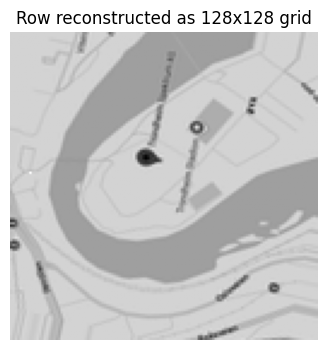

In [19]:
def reveal_picture(row):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(row.values.reshape(128, 128), cmap='gray')
    ax.axis('off')
    ax.set_title("Row reconstructed as 128x128 grid")
    plt.show()

reveal_picture(data.iloc[0][1:])


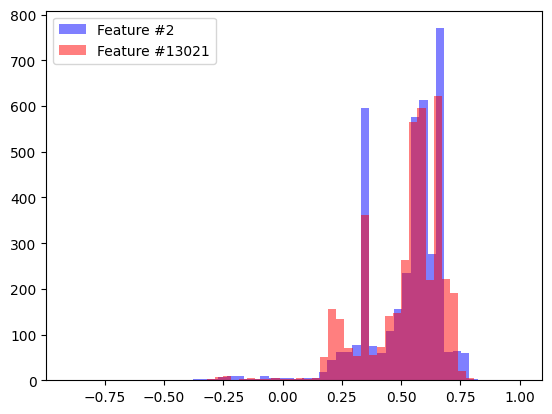

In [20]:
# Features seem to be similarly distributed...
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.legend()
plt.show()

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=50)
X_embedded = tsne.fit_transform(data.drop(columns=['ID']).values)

In [22]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,cluster
0,0,2
1,1,6
2,2,3
3,3,3
4,4,8
...,...,...
3995,3995,3
3996,3996,7
3997,3997,3
3998,3998,7


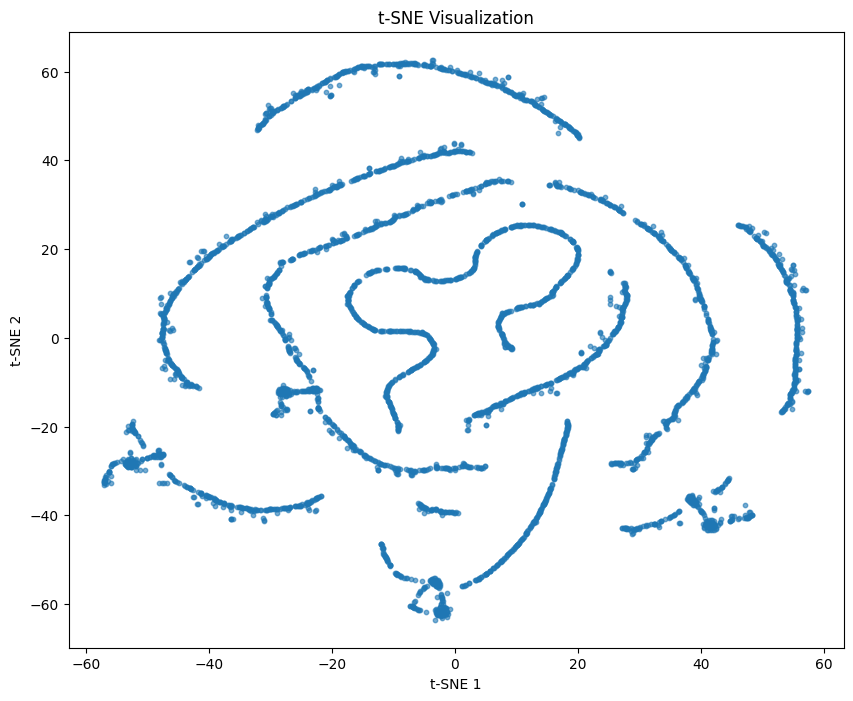

In [23]:
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6, s=10)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

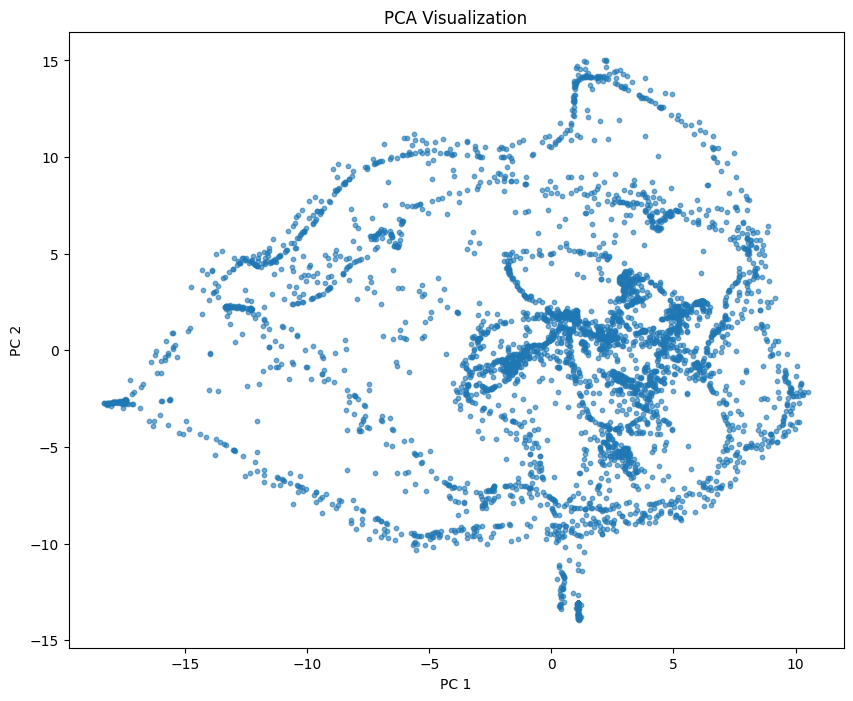

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.drop(columns=['ID']).values)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=10)
plt.title('PCA Visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

/home/nikolai/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nikolai/.pyenv/versions/3.12.11/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


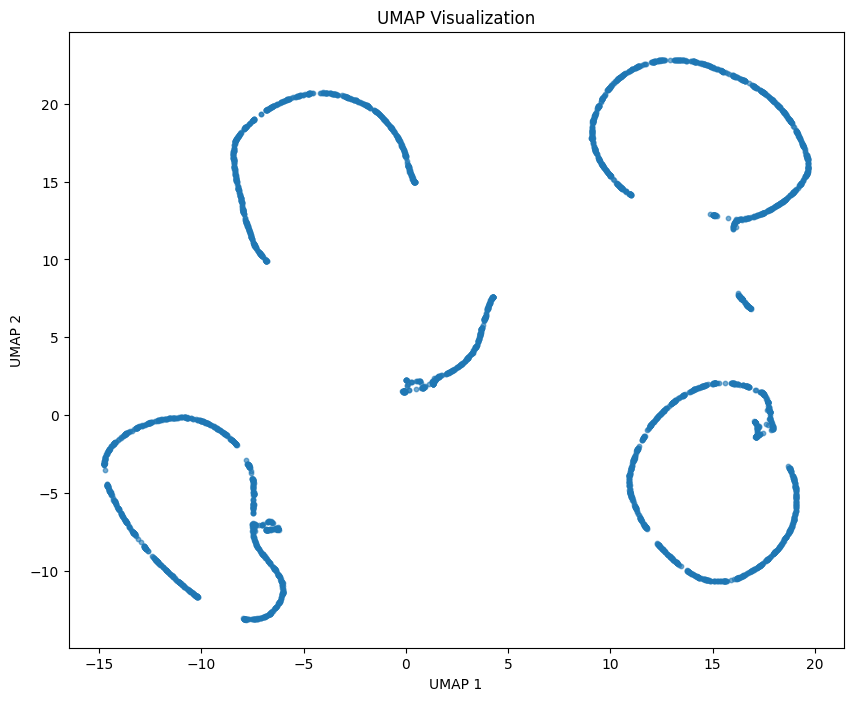

In [25]:
import umap

umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(data.drop(columns=['ID']).values)

plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.6, s=10)
plt.title('UMAP Visualization')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [26]:
# Based on UMAP, will try different n_clusters below depending on distinct shapes

from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_umap)

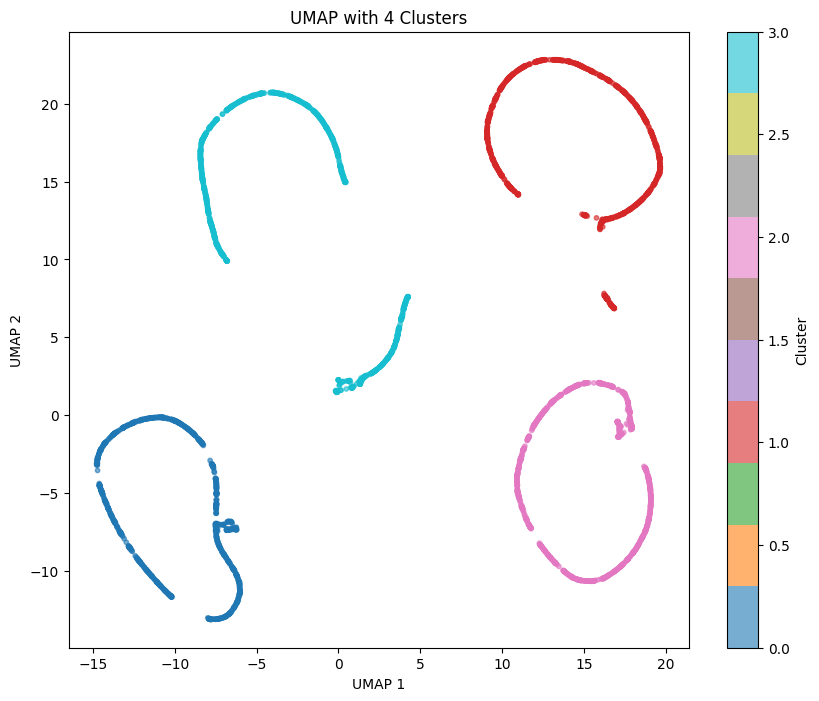

In [27]:
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(label='Cluster')
plt.title(f'UMAP with {n_clusters} Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [28]:
submission = pd.DataFrame({
    'ID': data['ID'],
    'cluster': cluster_labels
})
submission.to_csv('submission.csv', index=False)
submission.head()

,ID,cluster
0,0,2
1,1,3
2,2,2
3,3,3
4,4,0


In [29]:
print(submission['cluster'].value_counts())

cluster
2    1000
3    1000
0    1000
1    1000
Name: count, dtype: int64


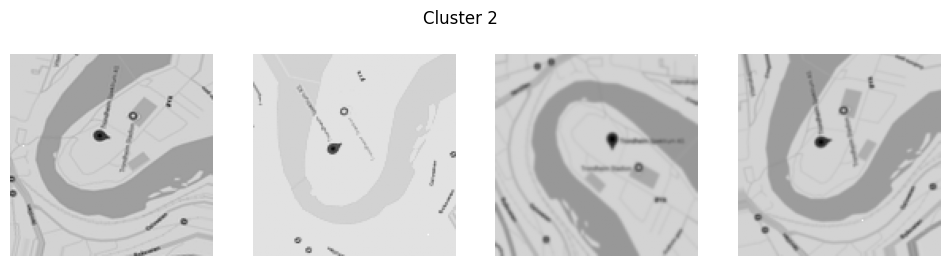

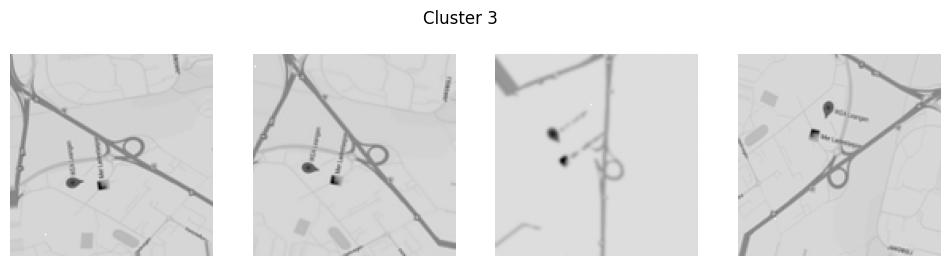

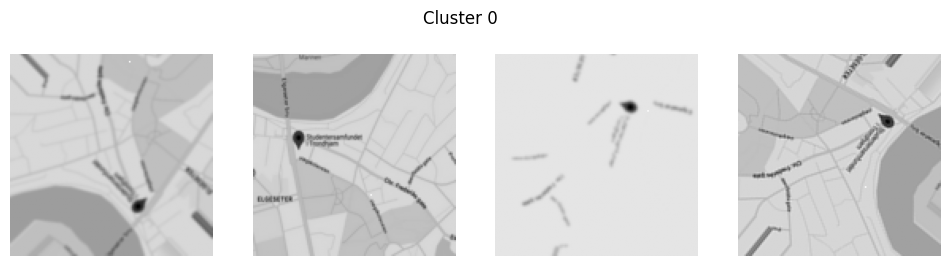

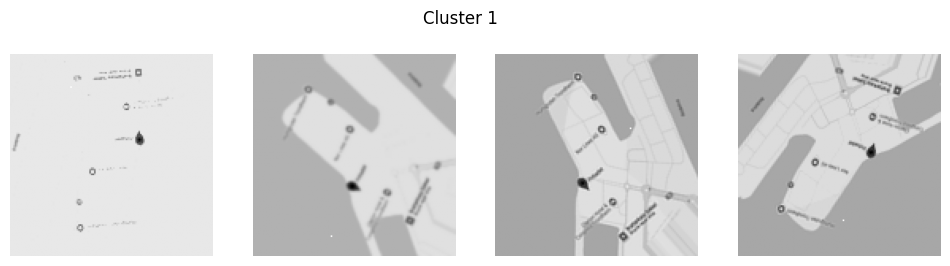

In [30]:
for cluster_id in submission['cluster'].unique():
    plt.figure(figsize=(12, 3))
    cluster_indices = submission[submission['cluster'] == cluster_id].index
    for i in range(min(4, len(cluster_indices))):
        plt.subplot(1, 4, i + 1)
        row = data.iloc[cluster_indices[i], 1:]
        plt.imshow(row.values.reshape(128, 128), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {cluster_id}')
    plt.show()



### Discussion: Mission 2.2

**Dimensionality Reduction**: Which methods helped determine cluster count? Why did some work better?

t-SNE and UMAP revealed distinct cluster structures, while PCA showed limited separation. t-SNE preserves local neighborhoods, creating tight clusters. UMAP balances local and global structure, maintaining broader relationships. PCA only captures linear variance, missing the non-linear patterns in image data.

**Clustering Approach**: Which algorithm and hyperparameters?

KMeans with k=4 clusters on UMAP embeddings. KMeans assumes spherical clusters and requires specifying k, suitable when cluster count is known from visualization. DBSCAN finds arbitrary shapes and handles noise but requires distance thresholds—difficult with high-dimensional embeddings where distances are less meaningful.

**Data Type**: What is the hidden data type? How does it influence feature extraction?

Images (128×128 grayscale). Raw pixel features are high-dimensional and correlated. Non-linear dimensionality reduction (t-SNE/UMAP) captures semantic similarity better than PCA because images have complex, non-linear manifold structures. Nearby pixels matter more than distant ones—exactly what t-SNE/UMAP preserve.

**Server Locations**: Which facilities in Trondheim?

cluster 0: Studentersamfundet i Trondhjem, cluster 1: pirbadet, cluster 2: Trondheim spektrum, cluster 3: ikea leangen


---

## 🎯 Note: Clustering Accuracy Evaluation

The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation is solely based on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [31]:
import numpy as np
import scipy.optimize
import sklearn.metrics

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy

In [32]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(1.0)

In [33]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.3333333333333333)

In [34]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.5)